# Extracción de caracteristicas proyecto:
# Clasificación de supernovas de ALeRCE - ZTF
### Por Joaquin Zepeda y Benjamin Irarrazabal - Tutor: Pablo Montero


# Instalación de librerias ALeRCE

In [ ]:
# pyarrow might be needed to read the data
!python -m pip install Cython
!python -m pip install -e git+https://git@github.com/alercebroker/turbo-fats#egg=turbofats
!python -m pip install -e git+https://git@github.com/alercebroker/mhps#egg=mhps
!python -m pip install -e git+https://git@github.com/alercebroker/P4J#egg=P4J
!python -m pip install pyarrow
!python -m pip install -e git+https://git@github.com/alercebroker/lc_classifier#egg=lc_classifier

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
inicio_ejecucion = time.time()
# Se imprime la version de Tensorflow
print('Tensorflow version', tf.__version__)

Tensorflow version 2.4.0


# Se importan los extractores de caracteristicas provistos por lc_classifier ALeRCE

In [2]:
from lc_classifier.features import MHPSExtractor, PeriodExtractor, GPDRWExtractor
from lc_classifier.features import FoldedKimExtractor
from lc_classifier.features import HarmonicsExtractor, IQRExtractor, SupernovaeDetectionFeatureExtractor
from lc_classifier.features import PowerRateExtractor
from lc_classifier.features import TurboFatsFeatureExtractor

from lc_classifier.features import FeatureExtractorComposer

In [38]:
'''
2.- Los extractores de características recomendados son:

SupernovaeDetectionFeatureExtractor(band_names),
SNParametricModelExtractor(band_names),
IQRExtractor(band_names),
MHPSExtractor(band_names),
TurboFatsFeatureExtractor(band_names),
GPDRWExtractor(band_names),
PowerRateExtractor(band_names),
PeriodExtractor(band_names),
HarmonicsExtractor(band_names),

'''

# fid = {1 2} Indica la banda a la que corresponde (green, red) 
# bands = ['u', 'g', 'r']
bands = [1,2]
feature_extractor = FeatureExtractorComposer(
    [
        SupernovaeDetectionFeatureExtractor(bands),
        PeriodExtractor(bands),
        MHPSExtractor(bands),
        GPDRWExtractor(bands),
        FoldedKimExtractor(bands),
        HarmonicsExtractor(bands),
        PowerRateExtractor(bands),
        TurboFatsFeatureExtractor(bands)
    ]
)


# Se leen los datos de las detecciones de supernovas

In [6]:
url_det='https://raw.githubusercontent.com/joaquinzepeda/Datos/main/datos%20supernovas/detections_SNe_v7.0.1.csv'
url_dfcross='https://raw.githubusercontent.com/joaquinzepeda/Datos/main/datos%20supernovas/dfcrossmatches_prioritized_v7.0.1.csv'
detections = pd.read_csv(url_det, index_col=None)
dfcrossmatches = pd.read_csv(url_dfcross, index_col=None)

# Eliminación de outliers

In [39]:
from scipy import stats

Conjunto = pd.merge(detections, dfcrossmatches, left_on='objectId', right_on='oid')
slice_cjto = Conjunto[['oid','fid', 'isdiffpos', 'sigmapsf','sigmapsf_corr', 'field',
       'fwhm', 'dec_x', 'magpsf', 'magpsf_corr', 'rcid', 'ra_x', 'sky', 'rb', 'ssmagnr',
       'distpsnr3', 'sgscore2', 'maggaiabright', 'distpsnr2', 'distpsnr1',
       'maggaia', 'exptime', 'drb', 'sgscore3', 'neargaia', 'sgscore1', 'mjd', 'has_stamp', 'ra_y', 'dec_y', 'classALeRCE']]
clean_data = slice_cjto[((np.abs(stats.zscore(slice_cjto['magpsf']))<3)&(slice_cjto['sigmapsf']<1))]

n = len(clean_data)
copy_cleandata = clean_data.copy()


In [40]:
# Se obtienen los indices de las columnas magpsf_corr, sigmapsf_corr, esto permitira que 
# aunque se cambien de posición estas columnas siga funcionando el código, siempre y cuando las versiones no
# corregidas se encuentren a la izquierda de la columna corregida

j=0
indice_magpsf_corr = 0
indice_sigmapsf_corr = 0
indice_fid = 0
for columna in copy_cleandata.columns:
    if columna=='magpsf_corr':
        print(columna)
        indice_magpsf_corr = j
    if columna=='sigmapsf_corr':
        print(columna)
        indice_sigmapsf_corr = j
    if columna=='fid':
        print(columna)
        indice_fid = j
    j+=1
indice_magpsf_corr,indice_sigmapsf_corr ,fid

sigmapsf_corr
magpsf_corr


(9, 4)

# Arreglo de los datos corregidos

In [96]:
for i in range(0,n):
  if pd.isna(clean_data.iloc[i,indice_magpsf_corr]) == True:
    copy_cleandata.iloc[i,indice_magpsf_corr] = copy_cleandata.iloc[i,indice_magpsf_corr-1]
  if pd.isna(clean_data.iloc[i,indice_sigmapsf_corr ]) == True:
    copy_cleandata.iloc[i,indice_sigmapsf_corr ] = copy_cleandata.iloc[i,indice_sigmapsf_corr-1]

In [42]:
copy_cleandata.head()

,oid,fid,isdiffpos,sigmapsf,sigmapsf_corr,field,fwhm,dec_x,magpsf,magpsf_corr,...,exptime,drb,sgscore3,neargaia,sgscore1,mjd,has_stamp,ra_y,dec_y,classALeRCE
2,ZTF18aahvndq,1,1.0,0.032161,0.032161,626,1.98,27.008647,16.072975,16.072975,...,30.0,0.999939,0.5,78.111310,0.175976,59004.192674,True,198.722653,27.008637,SNIa
3,ZTF18aahvndq,1,1.0,0.049931,0.049931,626,2.75,27.008624,17.708502,17.708502,...,30.0,0.999956,0.5,78.077545,0.175976,59021.227604,True,198.722653,27.008637,SNIa
6,ZTF18aahvndq,1,1.0,0.044748,0.044748,626,3.49,27.008622,16.626165,16.626165,...,30.0,0.999150,0.5,78.058230,0.175976,59009.258669,True,198.722653,27.008637,SNIa
8,ZTF18aahvndq,1,1.0,0.078094,0.078094,626,2.24,27.008641,18.192377,18.192377,...,30.0,0.999988,0.5,78.038506,0.175976,59036.198090,True,198.722653,27.008637,SNIa
9,ZTF18aahvndq,1,1.0,0.083104,0.083104,626,2.28,27.008652,18.481302,18.481302,...,30.0,0.999997,0.5,78.075700,0.175976,59045.238090,False,198.722653,27.008637,SNIa


In [43]:
# Ahora, tomaremos un ejemplo de cada supernova y graficaremos su curva de luz.
datos_final = copy_cleandata #Las muestras con los NaN reemplazados y sin outliers

In [45]:
try:
    datos_final = datos_final.set_index('oid')
except:
    print('oid is already the index')
datos_final.head()

,fid,isdiffpos,sigmapsf,sigmapsf_corr,field,fwhm,dec_x,magpsf,magpsf_corr,rcid,...,exptime,drb,sgscore3,neargaia,sgscore1,mjd,has_stamp,ra_y,dec_y,classALeRCE
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18aahvndq,1,1.0,0.032161,0.032161,626,1.98,27.008647,16.072975,16.072975,34,...,30.0,0.999939,0.5,78.111310,0.175976,59004.192674,True,198.722653,27.008637,SNIa
ZTF18aahvndq,1,1.0,0.049931,0.049931,626,2.75,27.008624,17.708502,17.708502,34,...,30.0,0.999956,0.5,78.077545,0.175976,59021.227604,True,198.722653,27.008637,SNIa
ZTF18aahvndq,1,1.0,0.044748,0.044748,626,3.49,27.008622,16.626165,16.626165,34,...,30.0,0.999150,0.5,78.058230,0.175976,59009.258669,True,198.722653,27.008637,SNIa
ZTF18aahvndq,1,1.0,0.078094,0.078094,626,2.24,27.008641,18.192377,18.192377,34,...,30.0,0.999988,0.5,78.038506,0.175976,59036.198090,True,198.722653,27.008637,SNIa
ZTF18aahvndq,1,1.0,0.083104,0.083104,626,2.28,27.008652,18.481302,18.481302,34,...,30.0,0.999997,0.5,78.075700,0.175976,59045.238090,False,198.722653,27.008637,SNIa


# Extracción de caracteristicas
## Esta sección se demora entre 15 y 25 minutos, dependiendo de los recursos computacionales que se tengan disponibles.

In [46]:
import warnings
import time
warnings.filterwarnings("ignore")
inicio = time.time()

detections_df= datos_final.rename(columns={'magpsf':'magnitude','mjd':'time', 'fid':'band','sigmapsf':'error'})
features = feature_extractor.compute_features(detections_df)
fin = time.time()
features

ERROR:root:TypeError exception in PeriodExtractor: oid ZTF19aawgopm
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF19acihlft
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF20aamuqwn
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF20aavpnlv
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF20aaynrrh
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF19aawgopm
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF19acihlft
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF20aamuqwn
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF20aavpnlv
'NoneType' object is not iterable
ERROR:root:TypeError exception in PeriodExtractor: oid ZTF20aaynrrh
'NoneType' obj

,delta_mag_fid_1,delta_mjd_fid_1,first_mag_1,mean_mag_1,min_mag_1,n_det_1,n_neg_1,n_pos_1,positive_fraction_1,delta_mag_fid_2,...,Skew_2,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aadlxmv,2.244800,42.055613,19.879980,19.087656,17.947500,18.0,0.0,18.0,1.0,1.847730,...,0.767211,1.142780,0.466788,0.893531,1.000000,0.000594,1.874733,0.348850,0.838971,0.001989
ZTF18aaaqexr,0.896138,18.870671,19.133900,18.977915,18.447520,9.0,0.0,9.0,1.0,0.191736,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18aacdbzx,0.495977,19.991725,19.741877,19.620142,19.432064,14.0,0.0,14.0,1.0,0.786995,...,1.301440,2.497958,0.212669,0.743787,0.999385,0.000068,6.512830,0.948480,0.924340,0.017806
ZTF18aadmssd,3.293953,59.951100,16.887047,18.581230,16.887047,16.0,0.0,16.0,1.0,2.170098,...,-0.066124,-0.621467,0.662524,0.917680,1.000000,0.001411,8.845398,0.926170,0.988949,0.027800
ZTF18aadzfso,1.371363,32.999224,19.840900,19.273643,18.476837,24.0,0.0,24.0,1.0,0.797367,...,-0.444814,-0.743503,0.238186,0.886096,1.000000,0.000121,0.144780,-0.214761,0.899290,0.008069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF20abgbxfm,2.981503,68.950197,18.893476,19.555296,18.296597,58.0,0.0,58.0,1.0,2.216758,...,0.100401,-1.245222,0.664534,0.839586,1.000000,0.001109,11.378320,0.987949,0.991831,0.034059
ZTF20abgdtmv,2.669654,33.020729,18.728144,20.046770,18.663546,26.0,0.0,26.0,1.0,1.719614,...,0.070929,-0.974009,0.528035,0.858666,1.000000,0.000697,7.053065,0.740276,0.979279,0.039661
ZTF20abgfekk,1.627867,31.928044,19.095242,17.742374,17.467375,32.0,0.0,32.0,1.0,1.534458,...,2.443501,6.694064,0.364999,0.679766,1.000000,0.000406,15.000000,1.116547,0.952584,-0.026970


In [47]:
tiempo_de_extraccion = (fin-inicio)/60
print(f'La extracción de caracteristicas se demoro {"{:.2f}".format(tiempo_de_extraccion)} minutos')

La extracción de caracteristicas se demoro 16.12 minutos


In [50]:
#Ejecutar una sola vez
ejecutado = False
if ejecutado == False:
    features.reset_index()
    ejecutado = True
else:
    print('ya fue reseteado el indice una vez, si quiere realizarlo nuevamente porfavor cambie el valor de ejecutado')
features

,oid,delta_mag_fid_1,delta_mjd_fid_1,first_mag_1,mean_mag_1,min_mag_1,n_det_1,n_neg_1,n_pos_1,positive_fraction_1,...,Skew_2,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2
0,ZTF17aadlxmv,2.244800,42.055613,19.879980,19.087656,17.947500,18.0,0.0,18.0,1.0,...,0.767211,1.142780,0.466788,0.893531,1.000000,0.000594,1.874733,0.348850,0.838971,0.001989
1,ZTF18aaaqexr,0.896138,18.870671,19.133900,18.977915,18.447520,9.0,0.0,9.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ZTF18aacdbzx,0.495977,19.991725,19.741877,19.620142,19.432064,14.0,0.0,14.0,1.0,...,1.301440,2.497958,0.212669,0.743787,0.999385,0.000068,6.512830,0.948480,0.924340,0.017806
3,ZTF18aadmssd,3.293953,59.951100,16.887047,18.581230,16.887047,16.0,0.0,16.0,1.0,...,-0.066124,-0.621467,0.662524,0.917680,1.000000,0.001411,8.845398,0.926170,0.988949,0.027800
4,ZTF18aadzfso,1.371363,32.999224,19.840900,19.273643,18.476837,24.0,0.0,24.0,1.0,...,-0.444814,-0.743503,0.238186,0.886096,1.000000,0.000121,0.144780,-0.214761,0.899290,0.008069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,ZTF20abgbxfm,2.981503,68.950197,18.893476,19.555296,18.296597,58.0,0.0,58.0,1.0,...,0.100401,-1.245222,0.664534,0.839586,1.000000,0.001109,11.378320,0.987949,0.991831,0.034059
2064,ZTF20abgdtmv,2.669654,33.020729,18.728144,20.046770,18.663546,26.0,0.0,26.0,1.0,...,0.070929,-0.974009,0.528035,0.858666,1.000000,0.000697,7.053065,0.740276,0.979279,0.039661
2065,ZTF20abgfekk,1.627867,31.928044,19.095242,17.742374,17.467375,32.0,0.0,32.0,1.0,...,2.443501,6.694064,0.364999,0.679766,1.000000,0.000406,15.000000,1.116547,0.952584,-0.026970
2066,ZTF20abgfljj,1.344170,21.932766,19.791739,19.019873,18.447569,26.0,0.0,26.0,1.0,...,1.158201,1.331404,0.622109,0.826843,1.000000,0.000997,5.794355,0.578048,0.932772,-0.034009


# Se eliminan las caracteristicas no recomendadas

In [99]:
"""
banned_features = [
   'W1', 'W2', 'W3', 'W4',
   'iqr_1','iqr_2',
   'last_mjd_before_fid_1',
   'last_mjd_before_fid_2',
   'g-r_ml',
   'MHAOV_Period_1', 'MHAOV_Period_2'
]
"""


banned_features1 = ['mean_mag_1',
   'mean_mag_2',
   'min_mag_1',
   'min_mag_2',
   'delta_mjd_fid_1',
   'delta_mjd_fid_2',
   'Mean_1',
   'Mean_2',
   'n_det_1',
   'n_det_2',
   'n_pos_1',
   'n_pos_2',
   'n_neg_1',
   'n_neg_2',
   'first_mag_1',
   'first_mag_2',
   'MHPS_non_zero_1',
   'MHPS_non_zero_2',
   'MHPS_PN_flag_1',
   'MHPS_PN_flag_2']

# además se eliminan estas caracteristicas pues la mayoria de sus celdas son Nan
features_clean = features.drop(['Eta_e_1','MaxSlope_1','Eta_e_2','MaxSlope_2'], axis=1)
features_clean = features_clean.drop(banned_features1, axis=1)
features_plus_target = pd.merge(features_clean, dfcrossmatches[['oid','classALeRCE']], left_on='oid', right_on='oid')
features_plus_target 

,oid,delta_mag_fid_1,positive_fraction_1,delta_mag_fid_2,positive_fraction_2,Multiband_period,PPE,Period_band_1,delta_period_1,Period_band_2,...,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2,classALeRCE
0,ZTF17aadlxmv,2.244800,1.0,1.847730,1.0,51.630429,0.018797,0.200240,51.430189,0.069774,...,1.142780,0.466788,0.893531,1.000000,0.000594,1.874733,0.348850,0.838971,0.001989,SNIa
1,ZTF18aaaqexr,0.896138,1.0,0.191736,1.0,29.230770,0.000936,29.230770,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SNIa
2,ZTF18aacdbzx,0.495977,1.0,0.786995,1.0,0.156563,0.004384,0.165508,0.008945,0.185710,...,2.497958,0.212669,0.743787,0.999385,0.000068,6.512830,0.948480,0.924340,0.017806,SNIbc
3,ZTF18aadmssd,3.293953,1.0,2.170098,1.0,1.005344,0.056146,0.065053,0.940291,999.999953,...,-0.621467,0.662524,0.917680,1.000000,0.001411,8.845398,0.926170,0.988949,0.027800,SNIIn
4,ZTF18aadzfso,1.371363,1.0,0.797367,1.0,1.028361,0.034737,1.029866,0.001505,37.037036,...,-0.743503,0.238186,0.886096,1.000000,0.000121,0.144780,-0.214761,0.899290,0.008069,SNIa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,ZTF20abgbxfm,2.981503,1.0,2.216758,1.0,104.972373,0.126945,90.909084,14.063289,142.857138,...,-1.245222,0.664534,0.839586,1.000000,0.001109,11.378320,0.987949,0.991831,0.034059,SNIa
2064,ZTF20abgdtmv,2.669654,1.0,1.719614,1.0,73.929961,0.074820,66.666664,7.263297,76.923075,...,-0.974009,0.528035,0.858666,1.000000,0.000697,7.053065,0.740276,0.979279,0.039661,SNIa
2065,ZTF20abgfekk,1.627867,1.0,1.534458,1.0,1.016858,0.042308,999.999953,998.983094,999.999953,...,6.694064,0.364999,0.679766,1.000000,0.000406,15.000000,1.116547,0.952584,-0.026970,SNIa
2066,ZTF20abgfljj,1.344170,1.0,2.227105,1.0,1.024148,0.016780,499.999976,498.975828,999.999953,...,1.331404,0.622109,0.826843,1.000000,0.000997,5.794355,0.578048,0.932772,-0.034009,SNIa


# EL valor del thresh es la cota de valores que se necesitan no nulos para que la fila no sea eliminada

In [101]:
thresh = features_plus_target.shape[1]
thresh

106

# Mantenga solo las filas con al menos 106 valores que no sean NA.

In [102]:
features_plus_target_thresh = features_plus_target.dropna(thresh=thresh)
features_plus_target_thresh 

,oid,delta_mag_fid_1,positive_fraction_1,delta_mag_fid_2,positive_fraction_2,Multiband_period,PPE,Period_band_1,delta_period_1,Period_band_2,...,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2,classALeRCE
0,ZTF17aadlxmv,2.244800,1.0,1.847730,1.0,51.630429,0.018797,0.200240,51.430189,0.069774,...,1.142780,0.466788,0.893531,1.000000,0.000594,1.874733,0.348850,0.838971,0.001989,SNIa
2,ZTF18aacdbzx,0.495977,1.0,0.786995,1.0,0.156563,0.004384,0.165508,0.008945,0.185710,...,2.497958,0.212669,0.743787,0.999385,0.000068,6.512830,0.948480,0.924340,0.017806,SNIbc
3,ZTF18aadmssd,3.293953,1.0,2.170098,1.0,1.005344,0.056146,0.065053,0.940291,999.999953,...,-0.621467,0.662524,0.917680,1.000000,0.001411,8.845398,0.926170,0.988949,0.027800,SNIIn
4,ZTF18aadzfso,1.371363,1.0,0.797367,1.0,1.028361,0.034737,1.029866,0.001505,37.037036,...,-0.743503,0.238186,0.886096,1.000000,0.000121,0.144780,-0.214761,0.899290,0.008069,SNIa
5,ZTF18aaermez,0.728745,1.0,1.682007,1.0,0.117252,0.008665,0.159770,0.042518,0.183438,...,-0.604936,0.542122,0.865536,1.000000,0.000816,0.185903,-0.458004,0.690001,0.012075,SNIa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,ZTF20abgbxfm,2.981503,1.0,2.216758,1.0,104.972373,0.126945,90.909084,14.063289,142.857138,...,-1.245222,0.664534,0.839586,1.000000,0.001109,11.378320,0.987949,0.991831,0.034059,SNIa
2064,ZTF20abgdtmv,2.669654,1.0,1.719614,1.0,73.929961,0.074820,66.666664,7.263297,76.923075,...,-0.974009,0.528035,0.858666,1.000000,0.000697,7.053065,0.740276,0.979279,0.039661,SNIa
2065,ZTF20abgfekk,1.627867,1.0,1.534458,1.0,1.016858,0.042308,999.999953,998.983094,999.999953,...,6.694064,0.364999,0.679766,1.000000,0.000406,15.000000,1.116547,0.952584,-0.026970,SNIa
2066,ZTF20abgfljj,1.344170,1.0,2.227105,1.0,1.024148,0.016780,499.999976,498.975828,999.999953,...,1.331404,0.622109,0.826843,1.000000,0.000997,5.794355,0.578048,0.932772,-0.034009,SNIa


In [103]:
features_plus_target = features_plus_target_thresh 

# Balancear los datos: Oversampling the minority class

In [133]:
# tomamos un subslice de los datos tomando solo la columna del Id con la de la clase:

subslice2 = features_plus_target[['oid','classALeRCE']]
# Ahora, a este subslice, le eliminamos los "duplicados" de cada curva para poder obtener la cantidad de supernovas que tenemos
subslice_sinduplicados2 = subslice2.drop_duplicates(subset=['oid'])
# Y ahora que ya tenemos esto, podemos calcular la cantidad de supernovas real que hay, es decir, tomando solo 1 muestra para c/u
subslice_sinduplicados2 = subslice_sinduplicados2.groupby('classALeRCE').count()
subslice_sinduplicados2

,oid
classALeRCE,
SLSN,33
SNII,281
SNIIb,11
SNIIn,38
SNIa,1166
SNIbc,76


<AxesSubplot:xlabel='classALeRCE'>

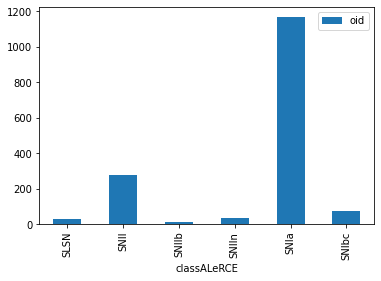

In [134]:
subslice_sinduplicados2.plot(kind='bar')


In [107]:
print(features_plus_target.shape)
TOTAL_DE_FEATURES=features_plus_target.shape[1]-1
print('TOTAL_DE_FEATURES: ',TOTAL_DE_FEATURES)

(1605, 106)
TOTAL_DE_FEATURES:  105


In [108]:
features_plus_target.head()

,oid,delta_mag_fid_1,positive_fraction_1,delta_mag_fid_2,positive_fraction_2,Multiband_period,PPE,Period_band_1,delta_period_1,Period_band_2,...,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2,classALeRCE
0,ZTF17aadlxmv,2.244800,1.0,1.847730,1.0,51.630429,0.018797,0.200240,51.430189,0.069774,...,1.142780,0.466788,0.893531,1.000000,0.000594,1.874733,0.348850,0.838971,0.001989,SNIa
2,ZTF18aacdbzx,0.495977,1.0,0.786995,1.0,0.156563,0.004384,0.165508,0.008945,0.185710,...,2.497958,0.212669,0.743787,0.999385,0.000068,6.512830,0.948480,0.924340,0.017806,SNIbc
3,ZTF18aadmssd,3.293953,1.0,2.170098,1.0,1.005344,0.056146,0.065053,0.940291,999.999953,...,-0.621467,0.662524,0.917680,1.000000,0.001411,8.845398,0.926170,0.988949,0.027800,SNIIn
4,ZTF18aadzfso,1.371363,1.0,0.797367,1.0,1.028361,0.034737,1.029866,0.001505,37.037036,...,-0.743503,0.238186,0.886096,1.000000,0.000121,0.144780,-0.214761,0.899290,0.008069,SNIa
5,ZTF18aaermez,0.728745,1.0,1.682007,1.0,0.117252,0.008665,0.159770,0.042518,0.183438,...,-0.604936,0.542122,0.865536,1.000000,0.000816,0.185903,-0.458004,0.690001,0.012075,SNIa


In [109]:
#features por utilizar, se puede setear un menor valor de features si se requiere
NUMERO_DE_FEATURES = TOTAL_DE_FEATURES

In [110]:
features_clean_target=features_plus_target

In [111]:
features_clean_target

,oid,delta_mag_fid_1,positive_fraction_1,delta_mag_fid_2,positive_fraction_2,Multiband_period,PPE,Period_band_1,delta_period_1,Period_band_2,...,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2,classALeRCE
0,ZTF17aadlxmv,2.244800,1.0,1.847730,1.0,51.630429,0.018797,0.200240,51.430189,0.069774,...,1.142780,0.466788,0.893531,1.000000,0.000594,1.874733,0.348850,0.838971,0.001989,SNIa
2,ZTF18aacdbzx,0.495977,1.0,0.786995,1.0,0.156563,0.004384,0.165508,0.008945,0.185710,...,2.497958,0.212669,0.743787,0.999385,0.000068,6.512830,0.948480,0.924340,0.017806,SNIbc
3,ZTF18aadmssd,3.293953,1.0,2.170098,1.0,1.005344,0.056146,0.065053,0.940291,999.999953,...,-0.621467,0.662524,0.917680,1.000000,0.001411,8.845398,0.926170,0.988949,0.027800,SNIIn
4,ZTF18aadzfso,1.371363,1.0,0.797367,1.0,1.028361,0.034737,1.029866,0.001505,37.037036,...,-0.743503,0.238186,0.886096,1.000000,0.000121,0.144780,-0.214761,0.899290,0.008069,SNIa
5,ZTF18aaermez,0.728745,1.0,1.682007,1.0,0.117252,0.008665,0.159770,0.042518,0.183438,...,-0.604936,0.542122,0.865536,1.000000,0.000816,0.185903,-0.458004,0.690001,0.012075,SNIa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,ZTF20abgbxfm,2.981503,1.0,2.216758,1.0,104.972373,0.126945,90.909084,14.063289,142.857138,...,-1.245222,0.664534,0.839586,1.000000,0.001109,11.378320,0.987949,0.991831,0.034059,SNIa
2064,ZTF20abgdtmv,2.669654,1.0,1.719614,1.0,73.929961,0.074820,66.666664,7.263297,76.923075,...,-0.974009,0.528035,0.858666,1.000000,0.000697,7.053065,0.740276,0.979279,0.039661,SNIa
2065,ZTF20abgfekk,1.627867,1.0,1.534458,1.0,1.016858,0.042308,999.999953,998.983094,999.999953,...,6.694064,0.364999,0.679766,1.000000,0.000406,15.000000,1.116547,0.952584,-0.026970,SNIa
2066,ZTF20abgfljj,1.344170,1.0,2.227105,1.0,1.024148,0.016780,499.999976,498.975828,999.999953,...,1.331404,0.622109,0.826843,1.000000,0.000997,5.794355,0.578048,0.932772,-0.034009,SNIa


In [112]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder # se codifica la clase

le = LabelEncoder()
X, y = features_clean_target.iloc[:,1:NUMERO_DE_FEATURES], features_clean_target['classALeRCE']

try:
    X = X.drop('classALeRCE',axis=1)
except:
    print('X no contiene classALeRCE')

# split into input and output elements
# Tira error debido a los Nan's ValueError: Input contains NaN,
#X, y = features_plus_target.iloc[:,1:TOTAL_DE_FEATURES-1], features_plus_target['classALeRCE']
oid = features_clean_target['oid']
y_sin_codificar = features_clean_target['classALeRCE']
# label encode the target variable
y = le.fit_transform(y)
print('y codificado',y)
print('y sin codificar',y_sin_codificar)
# transform the dataset

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)


X no contiene classALeRCE
y codificado [4 5 3 ... 4 4 4]
y sin codificar 0        SNIa
2       SNIbc
3       SNIIn
4        SNIa
5        SNIa
        ...  
2063     SNIa
2064     SNIa
2065     SNIa
2066     SNIa
2067     SNIa
Name: classALeRCE, Length: 1605, dtype: object


In [113]:
print(X.shape)
print(y.shape,type(y))
y_sin_codificar = le.inverse_transform(y)

(6996, 104)
(6996,) <class 'numpy.ndarray'>


In [114]:
features_smote = X
features_smote['ClassALeRCE']=y_sin_codificar
features_smote 

,delta_mag_fid_1,positive_fraction_1,delta_mag_fid_2,positive_fraction_2,Multiband_period,PPE,Period_band_1,delta_period_1,Period_band_2,delta_period_2,...,SmallKurtosis_2,Std_2,StetsonK_2,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,IAR_phi_2,LinearTrend_2,ClassALeRCE
0,2.244800,1.0,1.847730,1.0,51.630429,0.018797,0.200240,51.430189,0.069774,51.560655,...,1.142780,0.466788,0.893531,1.000000,0.000594,1.874733,0.348850,0.838971,0.001989,SNIa
1,0.495977,1.0,0.786995,1.0,0.156563,0.004384,0.165508,0.008945,0.185710,0.029147,...,2.497958,0.212669,0.743787,0.999385,0.000068,6.512830,0.948480,0.924340,0.017806,SNIbc
2,3.293953,1.0,2.170098,1.0,1.005344,0.056146,0.065053,0.940291,999.999953,998.994608,...,-0.621467,0.662524,0.917680,1.000000,0.001411,8.845398,0.926170,0.988949,0.027800,SNIIn
3,1.371363,1.0,0.797367,1.0,1.028361,0.034737,1.029866,0.001505,37.037036,36.008675,...,-0.743503,0.238186,0.886096,1.000000,0.000121,0.144780,-0.214761,0.899290,0.008069,SNIa
4,0.728745,1.0,1.682007,1.0,0.117252,0.008665,0.159770,0.042518,0.183438,0.066186,...,-0.604936,0.542122,0.865536,1.000000,0.000816,0.185903,-0.458004,0.690001,0.012075,SNIa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6991,1.834150,1.0,1.763415,1.0,85.014707,0.025007,0.146647,84.868060,76.695999,8.318709,...,-1.271869,0.615246,0.936865,1.000000,0.000985,12.231234,1.130425,0.977872,0.021137,SNIbc
6992,1.484125,1.0,1.549673,1.0,58.885080,0.087359,0.169465,58.715615,60.456962,1.571882,...,-1.372308,0.517632,0.928139,1.000000,0.000681,9.421385,0.872538,0.980311,0.036762,SNIbc
6993,1.623183,1.0,1.157998,1.0,56.541414,0.046717,65.906366,45.125617,31.716621,24.824793,...,-0.790042,0.360607,0.826086,1.000000,0.000299,2.582443,0.527793,0.921288,0.007377,SNIbc
6994,2.802999,1.0,2.802781,1.0,55.388475,0.070948,497.362846,551.615628,303.538554,248.150079,...,-0.293264,0.744054,0.855970,1.000000,0.001775,5.035447,0.824624,0.989714,0.020814,SNIbc


In [131]:
# tomamos un subslice de los datos tomando solo la columna del Id con la de la clase:
subslice4 = features_smote[['delta_mag_fid_1','ClassALeRCE']]

group_subslice4 = subslice4.groupby('ClassALeRCE').count().rename(columns={'delta_mag_fid_1':'Count'})
group_subslice4

,Count
ClassALeRCE,
SLSN,1166
SNII,1166
SNIIb,1166
SNIIn,1166
SNIa,1166
SNIbc,1166


<AxesSubplot:xlabel='ClassALeRCE'>

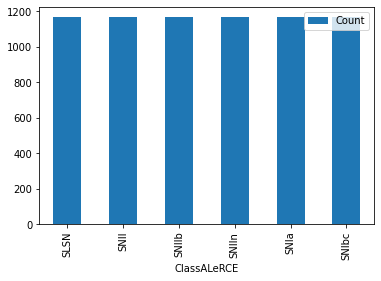

In [132]:
group_subslice4.plot(kind='bar')


In [ ]:
features_smote.to_csv('features_clean_smote.csv',index=False)